## __Prediction of Steam Game Rating Based on Pre-Release Factors__
For this project I was curious as to the ability of a model to accurately predict a games overall Steam rating based on data unrelated to player count, number of ratings, etc.
Instead I chose to focus on other aspects of released games, such as the price, release platforms, supported languages, and tags.
I hoped to determine the most important factors to successful games on Steam.

### __The Data__
The dataset was obtained on Kaggle from the following link:
https://www.kaggle.com/datasets/artermiloff/steam-games-dataset?select=games_may2024_cleaned.csv

It contains a recently updated database of video games on the PC platform Steam. The data was already cleaned of duplicates and playtest/beta versions of games.

Note:
This data does not contain any sales information and all conclusions are drawn based on overall receptiveness towards the games. In addition, this data only accounts for games sold on the platform Steam, and not other online retail platforms, or games sold for consoles.

In [216]:
import pandas as pd # for working with data
import numpy as np # for working with data
import seaborn as sns # for making visualizations
from matplotlib import pyplot as plt # for making visualizations
import sklearn as sk
import datetime as dt
import math
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [217]:
steam_df: pd.DataFrame = pd.read_csv('games_may2024_cleaned.csv')

I first decided on which columns were not strictly attainable after the release of a game. For example, peak concurrent player count was removed, as this is data that can only be gathered after the release of a game. 

In [218]:
columns_to_keep = [
    'required_age',
    'price',
    'dlc_count',
    'windows',
    'mac',
    'linux',
    'achievements',
    'supported_languages',
    'tags',
    'positive',
    'negative'
]

steam_df = steam_df.filter(columns_to_keep)

I then got the percentage of positive reviews for each game.

In [219]:
steam_df['total_review_count'] = steam_df['positive'] + steam_df['negative']
steam_df = steam_df[steam_df['total_review_count'] >= 10]

steam_df['positive_review_percentage'] = (steam_df['positive'] / steam_df['total_review_count']) * 100.0
steam_df = steam_df[steam_df['positive_review_percentage'].isna() == False]

This method was used to determine which category the game fell under. Steam uses a specific formula to bin the reviews based on the total number of reviews. This method takes the positive review percentage from above, to determine how the game is rated on Steam.

In [220]:
# Calculate Rating based on Steam rating standards
def calculate_steam_rating(num_reviews: int, prp: float) -> int:
    match num_reviews:
        case num_reviews if num_reviews <= 49:
            match prp:
                case prp if 0 <= prp <= 19.0:
                    return 6
                case prp if  29.0 <= prp <= 39.0:
                    return 5
                case prp if 40.0 <= prp <= 69.0:
                    return 4
                case prp if 70.0 <= prp <= 79.0:
                    return 3
                case prp if 80.0 <= prp <= 100.0:
                    return 2
        case num_reviews if 50 >= num_reviews <= 499:
            match prp:
                case prp if 0 <= prp <= 19.0:
                    return 7
                case prp if  29.0 <= prp <= 39.0:
                    return 5
                case prp if 40.0 <= prp <= 69.0:
                    return 4
                case prp if 70.0 <= prp <= 79.0:
                    return 3
                case prp if 80.0 <= prp <= 100.0:
                    return 1
        case num_reviews if 500 <= num_reviews <= 100_000_000:
            match prp:
                case prp if 0.0 <= prp <= 19.0:
                    return 8
                case prp if  29.0 <= prp <= 39.0:
                    return 5
                case prp if 40.0 <= prp <= 69.0:
                    return 4
                case prp if 70.0 <= prp <= 79.0:
                    return 3
                case prp if 80.0 <= prp <= 94.0:
                    return 1
                case prp if 95.0 <= prp <= 100.0:
                    return 0
                


I then apply the function to the steam_review column of the dataframe.
Next, I binned the price column by some standard price ranges on Steam to prevent too many columns from being created.

In [221]:
steam_df['steam_review'] = steam_df.apply(lambda x: calculate_steam_rating(x['total_review_count'], x['positive_review_percentage']), axis=1)

price_bin_edges = [0, 10, 15, 25, 30, 40, 60, np.inf]

price_labels = [f'{price_bin_edges[i]} - {price_bin_edges[i+1]}' for i in range(len(price_bin_edges)-1)]

steam_df['price_binned'] = pd.cut(steam_df['price'], bins=price_bin_edges, labels=price_labels, include_lowest=True)

The following code block performs a parse on the tags column. The tags column is represented as a string, and so we have to parse it into an array to use in out get_dummies function.

In [222]:

def parse_tags(tag_str):
    if pd.isna(tag_str):
        return {}
    try:
        return ast.literal_eval(tag_str)
    except (ValueError, SyntaxError):
        return {}


steam_df['tags'] = steam_df['tags'].apply(parse_tags)

tags_df = steam_df['tags'].apply(lambda tags: pd.Series({tag: 1 for tag in tags})).fillna(0)

steam_df = steam_df.drop(['tags'], axis=1)

tag_totals = tags_df.sum().sort_values(ascending=False)
N = 50
top_tags = tag_totals.head(N).index

tags_df = tags_df[top_tags]

steam_df = pd.concat([steam_df, tags_df], axis=1)

Similar to the code block above, we have to also parse the supported languages in a similar way. We apply an extra step of only including the most common languages that appear. 

In [223]:

from collections import Counter

def parse_languages(lang_str):
    if pd.isna(lang_str):
        return []
    try:
        return ast.literal_eval(lang_str)
    except (ValueError, SyntaxError):
        return []

steam_df['supported_languages'] = steam_df['supported_languages'].apply(parse_languages)

all_languages = [lang for langs in steam_df['supported_languages'] for lang in langs]
language_counts = Counter(all_languages)
most_common_languages = [lang for lang, count in language_counts.most_common(10)]

steam_df['supported_languages'] = steam_df['supported_languages'].apply(
    lambda langs: [lang for lang in langs if lang in most_common_languages]
)

mlb = MultiLabelBinarizer()
languages_dummies = pd.DataFrame(
    mlb.fit_transform(steam_df['supported_languages']),
    columns=mlb.classes_,
    index=steam_df.index
)

steam_df = pd.concat([steam_df, languages_dummies], axis=1)

steam_df.drop(columns=['supported_languages'], inplace=True)


For ease of use, I then select some columns to bin to prevent too many columns, as dlc_count, achievements, etc, can range from 0 to any arbitrary high number. 

In [224]:
columns_to_bin = [
    'required_age',
    'dlc_count',
    'achievements',
]

steam_df = steam_df.drop(['total_review_count', 'positive_review_percentage', 'negative', 'positive', 'price'], axis=1)

for col in columns_to_bin:
    if col in steam_df.columns:
        try:
            steam_df[col] = pd.to_numeric(steam_df[col], errors='coerce')
        except Exception as e:
            print(f"Error converting column {col} to numeric: {e}")

numeric_columns_to_bin = [col for col in columns_to_bin if steam_df[col].dtype in ['int64', 'float64']]

num_bins = 10
for col in numeric_columns_to_bin:
    if col in steam_df.columns:
        steam_df[f'{col}_binned'] = pd.qcut(steam_df[col], q=num_bins, duplicates='drop')

steam_df.drop(columns=numeric_columns_to_bin, inplace=True)

binned_columns = [f'{col}_binned' for col in numeric_columns_to_bin]
steam_df = pd.get_dummies(steam_df, columns=binned_columns)


A quick count plot to show how many games are in each rating.

        0               1           2           3           4               5       6               7           8                   9
Overwhelmingly Positive, Very Positive, Positive, Mostly Positive, Mixed, Mostly Negative, Negative, Very Negative, Overwhelmingly Negative

<Axes: xlabel='steam_review', ylabel='count'>

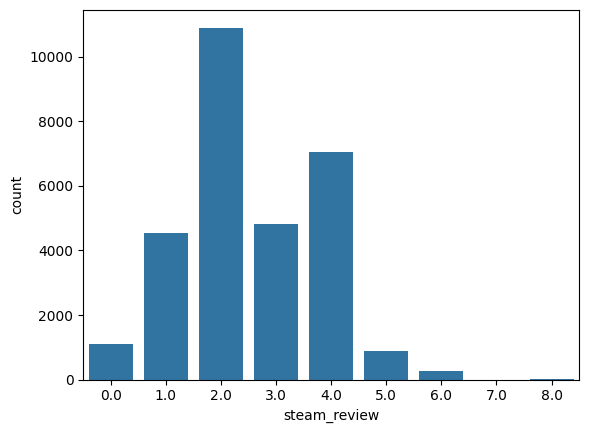

In [225]:

sns.countplot(data=steam_df, x='steam_review')


Then we remove the column we want to evaluate, and use the get_dummies function.

In [226]:
# Convert steam_reviews to ints
cols = list(steam_df.columns)
cols.remove('steam_review')

steam_df = pd.get_dummies(steam_df,  columns=cols)



In [227]:
X = steam_df.drop(columns = ['steam_review'])
y = steam_df['steam_review']
y.fillna(0, inplace=True)


In [228]:
from sklearn.model_selection import train_test_split

In [229]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [230]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36199, 152), (12067, 152), (36199,), (12067,))

In [231]:
from sklearn import tree

In [232]:
model = tree.DecisionTreeClassifier()

As you can see here, our score is honestly better than I expected it to be. Considering we are making a prediction on a games rating based soley on factors such as tags, and available languages.

In [233]:
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
score

0.3384436894008453

We then make our feature importance array for use in the bar plot.

In [234]:
fi = model.feature_importances_ #feature importance array
fi = pd.Series(data = fi, index = X.columns) #convert to Pandas series for plotting
fi.sort_values(ascending=False, inplace=True) #sort descending

C:\Users\noahe\AppData\Local\Temp\ipykernel_2240\736252593.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(x=fi, y=fi.index, palette=sns.color_palette("BuGn_r", n_colors=len(fi)))
C:\Users\noahe\AppData\Local\Temp\ipykernel_2240\736252593.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


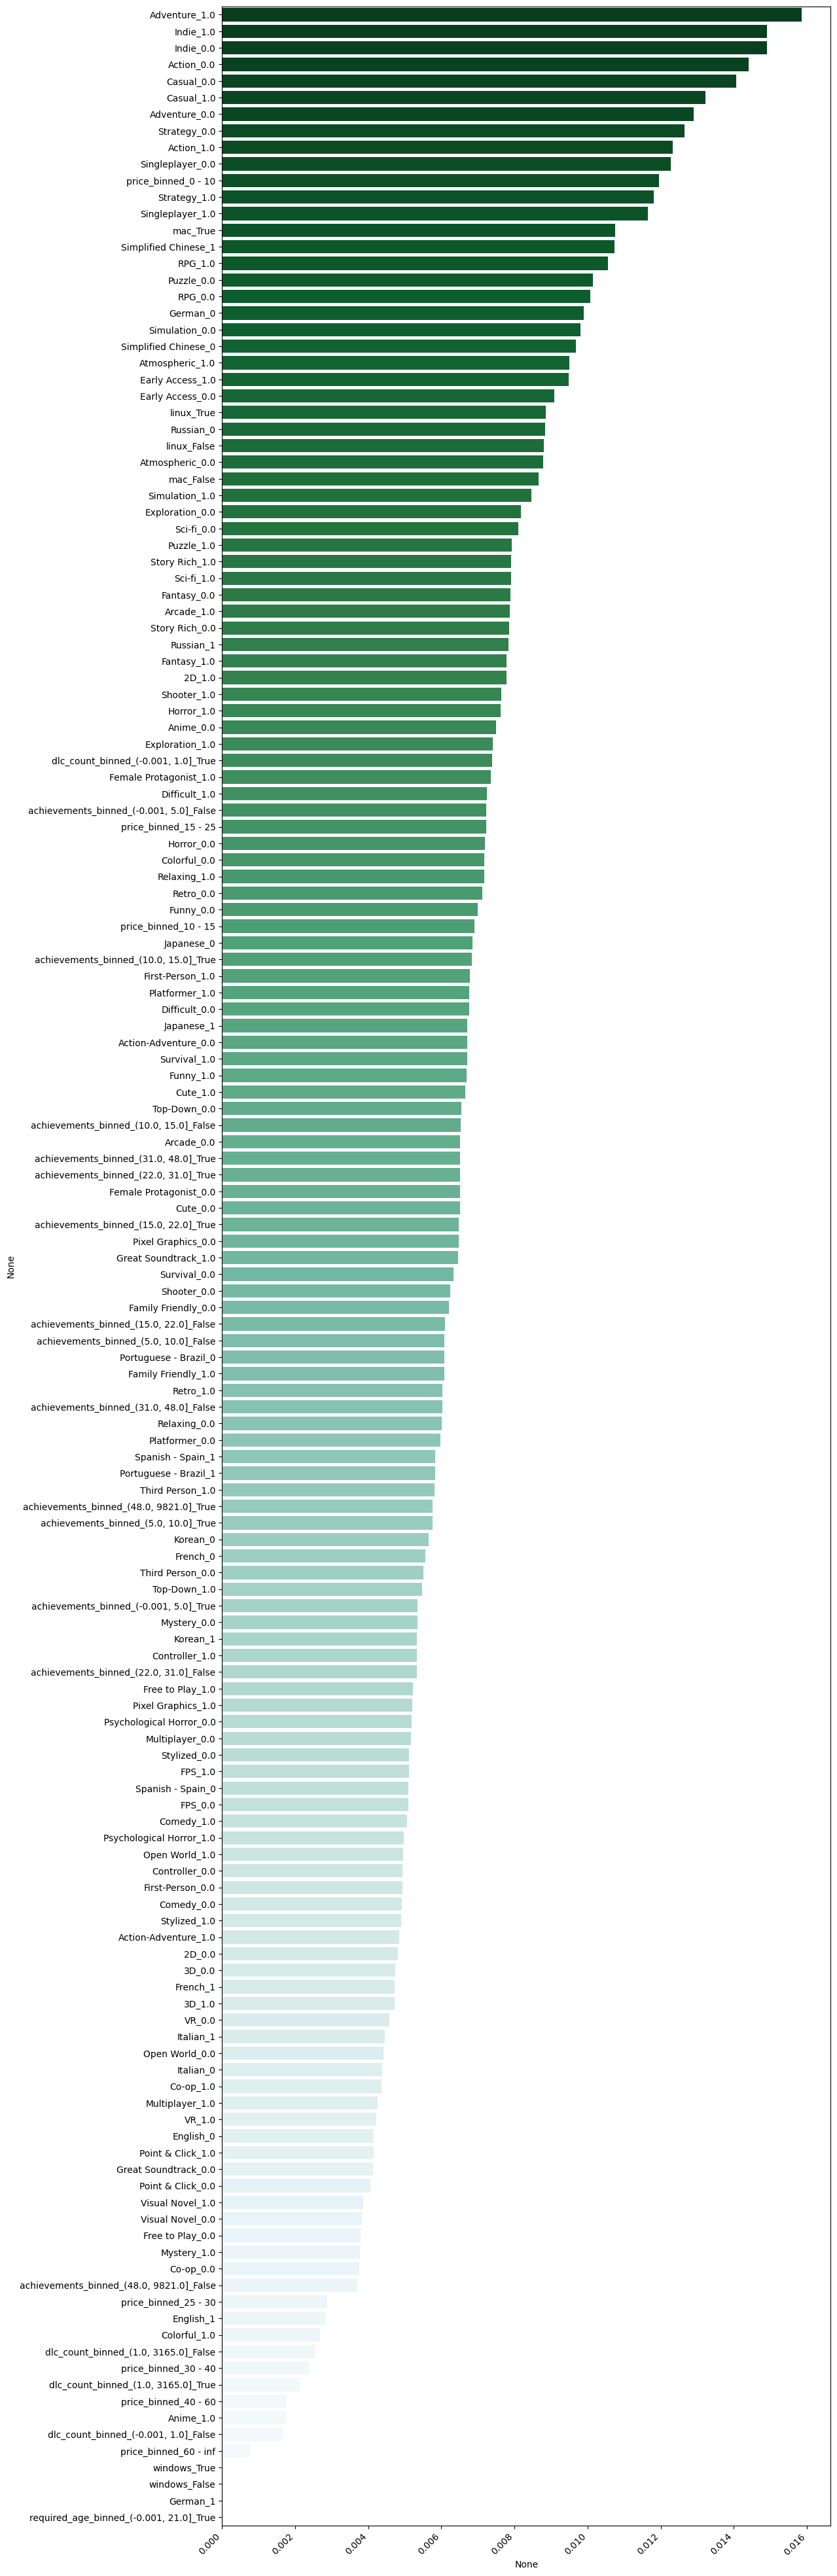

In [235]:
#create bar plot
plt.figure(figsize=(12, 50))
chart = sns.barplot(x=fi, y=fi.index, palette=sns.color_palette("BuGn_r", n_colors=len(fi)))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

The results above show the importance of each variable in predicting a games rating. We can see that many of the tags have an impact irregardless of the true or false value. This in turn makes it very difficult to actually tell if the tag itself has any impact at all.

In [236]:
from sklearn import metrics

In [237]:
predicted = model.predict(X_test)

In [238]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.46      0.47      0.47      4978
         1.0       0.26      0.24      0.25      1162
         2.0       0.34      0.35      0.35      2640
         3.0       0.12      0.13      0.12      1187
         4.0       0.21      0.20      0.20      1813
         5.0       0.07      0.06      0.07       227
         6.0       0.03      0.03      0.03        58
         7.0       0.00      0.00      0.00         1
         8.0       0.00      0.00      0.00         1

    accuracy                           0.34     12067
   macro avg       0.17      0.17      0.17     12067
weighted avg       0.34      0.34      0.34     12067



c:\Users\noahe\itsc3162\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noahe\itsc3162\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\noahe\itsc3162\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


The classification report reveals that the model is struggling due to class imbalance, as evidenced by better performance on more frequent classes like 0.0 and significantly worse performance on rare classes like 8.0 and 6.0. With an overall accuracy of 34% and low precision, recall, and F1-scores across most classes, the model is biased towards predicting the dominant classes, leading to poor predictions for minority classes. To improve performance, addressing class imbalance through oversampling, undersampling, or class weighting, along with potential hyperparameter tuning, model adjustments, or feature engineering, would be beneficial.

In [239]:
from sklearn.metrics import classification_report, confusion_matrix

In [240]:
confusion_matrix(y_test, predicted)

array([[2342,  483,  960,  465,  629,   82,   16,    0,    1],
       [ 480,  283,  121,  140,  124,   10,    4,    0,    0],
       [ 962,  108,  930,  250,  354,   24,   11,    0,    1],
       [ 442,  127,  244,  149,  201,   17,    6,    0,    1],
       [ 711,  103,  386,  187,  364,   44,   18,    0,    0],
       [  89,    3,   41,   19,   57,   14,    4,    0,    0],
       [  22,    2,   14,    5,   11,    2,    2,    0,    0],
       [   0,    0,    0,    0,    1,    0,    0,    0,    0],
       [   0,    0,    0,    1,    0,    0,    0,    0,    0]])

The confusion matrix reveals how well the model is predicting each class, showing both correct and incorrect predictions. The diagonal elements represent correct predictions, such as 2286 instances where class 0 was correctly predicted, and 942 instances where class 2 was correctly predicted. However, there are significant off-diagonal values, indicating misclassifications. For example, the model frequently confuses class 0 with class 2, as shown by the 976 instances where the model predicted class 0 instead of class 2. Similarly, class 4 is often misclassified as class 0, with 676 misclassifications. These patterns suggest that the model struggles to differentiate between several classes, leading to frequent misclassifications, particularly between neighboring classes in the dataset.

### __Impact__
This project could positively impact game developers by identifying key factors that contribute to a game's success on Steam, helping them make informed decisions about pricing, platforms, and features to improve ratings. However, there are ethical concerns, such as developers manipulating features to boost ratings without enhancing player experience, which could lead to a decline in game quality. Additionally, focusing on certain factors may reduce diversity in games, marginalize niche genres, and widen the gap between large studios and indie developers, potentially limiting innovation in the industry.

## __Storytelling__

Through the process of building a model to predict Steam game ratings, I gained several insights into the factors that influence a game's success. I focused on variables such as price, release platforms, supported languages, and tags, aiming to identify the most important contributors to high ratings. After analyzing the data and running the model, I found that certain tags and pricing strategies appeared to have a significant impact, while other factors like the number of supported languages were less influential. However, the model also revealed limitations in accurately capturing the full complexity of a game’s success, as subjective factors such as gameplay quality or community engagement are hard to quantify. This project helped me answer my initial question to some extent, showing key variables associated with high ratings, but also demonstrated that predicting game ratings is not an entirely straightforward task, as many unquantifiable elements play a role in shaping player feedback.